In [1]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.linear_model import LinearRegression

from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
import sklearn
from sklearn import pipeline, preprocessing, feature_extraction
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, auc, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from scipy import sparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import scipy
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%pylab inline

/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [15]:
def f1_score_single(y_true, y_pred):
    y_true = set(y_true)
    y_pred = set(y_pred)
    cross_size = len(y_true & y_pred)
    if cross_size == 0: return 0.
    p = 1. * cross_size / len(y_pred)
    r = 1. * cross_size / len(y_true)
    return 2 * p * r / (p + r)
    
def f1_score(y_true, y_pred):
    return np.mean([f1_score_single(x, y) for x, y in zip(y_true, y_pred)])

In [7]:
def load_data(path_data):
    '''
    --------------------------------order_product--------------------------------
    * Unique in order_id + product_id
    '''
    priors = pd.read_csv(path_data + 'order_products__prior.csv', 
                     dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    train = pd.read_csv(path_data + 'order_products__train.csv', 
                    dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    '''
    --------------------------------order--------------------------------
    * This file tells us which set (prior, train, test) an order belongs
    * Unique in order_id
    * order_id in train, prior, test has no intersection
    * this is the #order_number order of this user
    '''
    orders = pd.read_csv(path_data + 'orders.csv', 
                         dtype={
                                'order_id': np.int32,
                                'user_id': np.int64,
                                'eval_set': 'category',
                                'order_number': np.int16,
                                'order_dow': np.int8,
                                'order_hour_of_day': np.int8,
                                'days_since_prior_order': np.float32})

    #  order in prior, train, test has no duplicate
    #  order_ids_pri = priors.order_id.unique()
    #  order_ids_trn = train.order_id.unique()
    #  order_ids_tst = orders[orders.eval_set == 'test']['order_id'].unique()
    #  print(set(order_ids_pri).intersection(set(order_ids_trn)))
    #  print(set(order_ids_pri).intersection(set(order_ids_tst)))
    #  print(set(order_ids_trn).intersection(set(order_ids_tst)))

    '''
    --------------------------------product--------------------------------
    * Unique in product_id
    '''
    products = pd.read_csv(path_data + 'products.csv')
    aisles = pd.read_csv(path_data + "aisles.csv")
    departments = pd.read_csv(path_data + "departments.csv")
    sample_submission = pd.read_csv(path_data + "sample_submission.csv")
    
    return priors, train, orders, products, aisles, departments, sample_submission

class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))
            
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    '''Create statistical columns, group by [N columns] and compute stats on [N column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       agg_dict: python dictionary

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       {real_column_name: {your_specified_new_column_name : method}}
       agg_dict = {'user_id':{'prod_tot_cnts':'count'},
                   'reordered':{'reorder_tot_cnts_of_this_prod':'sum'},
                   'user_buy_product_times': {'prod_order_once':lambda x: sum(x==1),
                                              'prod_order_more_than_once':lambda x: sum(x==2)}}
       ka_add_stats_features_1_vs_n(train, ['product_id'], agg_dict)
    '''
    with tick_tock("add stats features"):
        try:
            if type(group_columns_list) == list:
                pass
            else:
                raise TypeError(k + "should be a list")
        except TypeError as e:
            print(e)
            raise

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped.agg(agg_dict)
        the_stats.columns = the_stats.columns.droplevel(0)
        the_stats.reset_index(inplace=True)
        if only_new_feature:
            df_new = the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    '''Create statistical columns, group by [N columns] and compute stats on [1 column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       target_columns_list: list_like
          column you want to compute stats, need to be a list with only one element
       methods_list: list_like
          methods that you want to use, all methods that supported by groupby in Pandas

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       ka_add_stats_features_n_vs_1(train, group_columns_list=['x0'], target_columns_list=['x10'])
    '''
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + "should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new

In [8]:
path_data = 'data/'
priors, train, orders, products, aisles, departments, sample_submission = load_data(path_data)

## Train из предпоследних товаров

In [19]:
prior_base = pd.merge(priors, orders, on=['order_id'], how='left')

tmp = pd.DataFrame(prior_base.groupby('user_id')['order_number'].max())
tmp.columns = ['max_order_number_']
tmp.reset_index(inplace=True)

prior_base = pd.merge(prior_base, tmp, on=['user_id'], how='left')
prior_base['to_new_train'] = prior_base['order_number'] == prior_base['max_order_number_']

new_train = prior_base[prior_base.to_new_train]
prior_base.drop(prior_base[prior_base.to_new_train].index, inplace=True)



del new_train['eval_set']
del new_train['max_order_number_']
del new_train['to_new_train']

train1 = new_train.copy()
train1= train1[['order_id','product_id','add_to_cart_order','reordered']]

del new_train['add_to_cart_order']


del prior_base['max_order_number_']
del prior_base['to_new_train']

In [6]:
prior_base1 = prior_base[['user_id', 'product_id']]
prior_base1 = prior_base1.drop_duplicates()

tmp = pd.DataFrame(new_train.groupby('order_id')['user_id'].mean())
tmp['order_id'] = tmp.index
tmp.index = tmp.user_id
new_train = pd.merge(prior_base1, tmp, on='user_id')

In [7]:
del new_train['user_id']
new_train = pd.merge(new_train, orders, on=['order_id'], how='left')
del new_train['eval_set']

new_train = pd.merge(new_train, train1, on=['order_id', 'product_id'], how='left')
del new_train['add_to_cart_order']
new_train = new_train.fillna(0)

## В train только юзеров из test

In [66]:
tmp = pd.merge(sample_submission, orders, on=['order_id'], how='left')
tmp = tmp[['user_id', 'order_id']]
tmp = pd.DataFrame(tmp.groupby('user_id')['order_id'].max())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'tmp']

new_train = pd.merge(new_train, tmp, on=['user_id'], how='left')
new_train['tmp'] = new_train['tmp'].isnull()
new_train['tmp'] = 1 - new_train['tmp']

new_train = new_train[new_train.tmp == 1]
del new_train['tmp']

In [118]:
import gc
gc.collect()

52380

In [19]:
1

1

## Train

In [14]:
X_train = pd.merge(train, orders, on=['order_id'], how='left')
prior_base = pd.merge(priors, orders, on=['order_id'], how='left')
prior_base = prior_base[['user_id', 'product_id']]
prior_base = prior_base.drop_duplicates()

tmp = pd.DataFrame(X_train.groupby('order_id')['user_id'].mean())
tmp['order_id'] = tmp.index
tmp.index = tmp.user_id
X_train = pd.merge(prior_base, tmp, on='user_id')
del X_train['user_id']
X_train = pd.merge(X_train, orders, on=['order_id'], how='left')
del X_train['eval_set']


X_train = pd.merge(X_train, train, on=['order_id', 'product_id'], how='left')
del X_train['add_to_cart_order']
X_train = X_train.fillna(0)

In [6]:
X_train[:7]

,product_id,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,33120,1050357,202279,9,1,14,30.0,1.0
1,28985,1050357,202279,9,1,14,30.0,0.0
2,9327,1050357,202279,9,1,14,30.0,0.0
3,45918,1050357,202279,9,1,14,30.0,0.0
4,30035,1050357,202279,9,1,14,30.0,0.0
5,17794,1050357,202279,9,1,14,30.0,0.0
6,40141,1050357,202279,9,1,14,30.0,0.0


In [8]:
X_train = new_train

In [20]:
# Количество раз, которое был куплен товар пользователем
prior_base = pd.merge(priors, orders, on=['order_id'], how='left')
tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['order_id'].count())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'ord_count']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Доля товара в заказах
X_train['part_ord'] = X_train['ord_count'] / X_train['order_number']

# Среднее место в корзине
tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'ave_add_to_cart_order']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Макс место в корзине
tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['add_to_cart_order'].max())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'max_add_to_cart_order']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Мин место в корзине
tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['add_to_cart_order'].min())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'min_add_to_cart_order']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Число заказов пользователя
tmp = pd.DataFrame(prior_base.groupby(['user_id'])['product_id'].count())
tmp['user_id'] = tmp.index
tmp.columns = ['tot_prod_count_user', 'user_id']
X_train = pd.merge(X_train, tmp, on=['user_id'], how='left')

# Доля заказов продукта пользователем ко всем заказам пользователя
X_train['tot_part_ord'] = X_train['ord_count'] / X_train['tot_prod_count_user']

# Средний размер корзины
X_train['ave_cart'] = X_train['tot_prod_count_user'] / X_train['order_number']

# Количество раз, которое товар покупался всего 
tmp = pd.DataFrame(prior_base.groupby(['product_id'])['product_id'].count())
tmp.columns = ['prod_tot_count']
tmp['product_id'] = tmp.index
tmp.columns = ['prod_tot_count', 'product_id']
X_train = pd.merge(X_train, tmp, on=['product_id'], how='left')

# Количество раз, которое товар перепокупался всего 
tmp = pd.DataFrame(prior_base[prior_base.reordered==1].groupby(['product_id'])['product_id'].count())
tmp.columns = ['prod_tot_reord_count']
tmp['product_id'] = tmp.index
tmp.columns = ['prod_tot_reord_count', 'product_id']
X_train = pd.merge(X_train, tmp, on=['product_id'], how='left')

# Доля перепокупок
X_train['tot_reord_part'] = X_train['prod_tot_reord_count'] / X_train['prod_tot_count']

# Номер предыдущего заказа товара
tmp = pd.DataFrame(prior_base.groupby(['user_id','product_id'])['order_number'].max())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'max_last_order']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Расстояние до предыдущего заказа
X_train['last_ord_dist'] = X_train['order_number'] - X_train['max_last_order']

# Ордер, в котором товар был куплен первый раз
tmp = pd.DataFrame(prior_base.groupby(['user_id','product_id'])['order_number'].min())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'min_last_order']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Расстояние до первого заказа
X_train['min_ord_dist'] = X_train['order_number'] - X_train['min_last_order']

# Расстояние между первой и последней покупкой
X_train['dist_min_max_ord'] = X_train['max_last_order'] - X_train['min_last_order']
# Среднее число заказов товара за ордер в этот период
X_train['ave_min_max_count'] = X_train['ord_count'] / X_train['dist_min_max_ord']

# Среднее число заказов товара за ордер с момента первой покупки
X_train['ave_min_count'] = X_train['ord_count'] / X_train['min_ord_dist']

# Среднее время между заказами
tmp = pd.DataFrame(prior_base.groupby(['user_id'])['days_since_prior_order'].mean())
tmp.columns = ['ave_time']
tmp['user_id'] = tmp.index
tmp.columns = ['ave_time', 'user_id']
X_train = pd.merge(X_train, tmp, on=['user_id'], how='left')

# Отношение времени до предыдущего заказа к среднему
X_train['rate_time'] = X_train['days_since_prior_order'] / X_train['ave_time']

In [21]:
X_train = pd.merge(X_train, products, on=['product_id'], how='left')
del X_train['product_name']

prior_base = pd.merge(prior_base, products, on=['product_id'], how='left')
prior_base = pd.merge(prior_base, pd.DataFrame(X_train[['user_id', 'product_id','max_last_order']]), on=['user_id', 'product_id'], how='left')

tmp = X_train[['user_id', 'product_id', 'order_number']]
tmp.columns = ['user_id', 'product_id', 'cur_order_number']
prior_base = pd.merge(prior_base, tmp, on=['user_id', 'product_id'], how='left')
prior_base['dist_to_ord'] = prior_base['cur_order_number'] - prior_base['order_number']


# Время в днях с последнего заказа пользователем этого товара
tmp = pd.DataFrame(prior_base.groupby(['user_id','order_number'])['order_id', 'days_since_prior_order'].mean())
tmp.reset_index(inplace=True)
del tmp['order_id']

tmp1 = pd.DataFrame(prior_base.groupby(['user_id','product_id'])['max_last_order'].mean())
tmp1.reset_index(inplace=True)

mask = pd.merge(tmp, tmp1, on=['user_id'], how='inner')['max_last_order'] < pd.merge(tmp, tmp1, on=['user_id'], how='inner')['order_number']
base = pd.merge(tmp, tmp1, on=['user_id'], how='inner')[mask]
base = pd.DataFrame(base.groupby(['user_id', 'product_id'])['days_since_prior_order'].sum())
base.columns = ['days_to last_buy']

base.reset_index(inplace=True)
X_train = pd.merge(X_train, base, on=['user_id', 'product_id'], how='left')



# Среднее число дней до предыдущего заказа по товару
tmp = pd.DataFrame(prior_base.groupby(['user_id','product_id'])['days_since_prior_order'].mean())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'ave_last_ord']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

In [22]:
tmp = pd.DataFrame(prior_base.groupby(['department_id'])['reordered'].mean())
tmp.columns = ['like_dep']
tmp['department_id'] = tmp.index
tmp.columns = ['like_dep', 'department_id']
X_train = pd.merge(X_train, tmp, on=['department_id'], how='left')

tmp = pd.DataFrame(prior_base.groupby(['aisle_id'])['reordered'].mean())
tmp.columns = ['like_aisle']
tmp['aisle_id'] = tmp.index
tmp.columns = ['like_aisle', 'aisle_id']
X_train = pd.merge(X_train, tmp, on=['aisle_id'], how='left')

tmp = pd.DataFrame(prior_base.groupby(['department_id', 'user_id'])['reordered'].mean())
tmp.columns = ['like_dep_user']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['department_id', 'user_id'], how='left')

tmp = pd.DataFrame(prior_base.groupby(['aisle_id', 'user_id'])['reordered'].mean())
tmp.columns = ['like_aisle_user']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['aisle_id', 'user_id'], how='left')

tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['reordered'].mean())
tmp.columns = ['like_user_prod']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

In [23]:
# Сколько раз товар покупался пользователем за последние 3 заказа
tmp = pd.DataFrame(prior_base[prior_base.dist_to_ord <= 3].groupby(['user_id', 'product_id'])['order_id'].count())
tmp.columns = ['last_3_count']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')
X_train['last_3_count'] = X_train['last_3_count'].fillna(0)

# Сколько раз товар покупался пользователем за последние 5 заказа
tmp = pd.DataFrame(prior_base[prior_base.dist_to_ord <= 5].groupby(['user_id', 'product_id'])['order_id'].count())
tmp.columns = ['last_5_count']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')
X_train['last_5_count'] = X_train['last_5_count'].fillna(0)

# Сколько раз товар покупался пользователем за последние 7 заказа
tmp = pd.DataFrame(prior_base[prior_base.dist_to_ord <= 7].groupby(['user_id', 'product_id'])['order_id'].count())
tmp.columns = ['last_7_count']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')
X_train['last_7_count'] = X_train['last_7_count'].fillna(0)

# Среднее время, когда покупался товар
tmp = pd.DataFrame(prior_base.groupby(['product_id'])['order_hour_of_day'].mean())
tmp['product_id'] = tmp.index
tmp.columns = ['ave_time_of_product', 'product_id']
X_train = pd.merge(X_train, tmp, on=['product_id'], how='left')

# Время до среднего времени заказа этого товара
X_train['dist_to_ave_time'] = np.abs(X_train['ave_time_of_product'] - X_train['order_hour_of_day'])

In [124]:
X_train.shape

(8474661, 43)

In [11]:
X_train[:4]

,product_id,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered,ord_count,part_ord,...,like_dep,like_aisle,like_dep_user,like_aisle_user,like_user_prod,last_3_count,last_5_count,last_7_count,ave_time_of_product,dist_to_ave_time
0,33120,1050357,202279,9,1,14,30.0,1.0,5,0.555556,...,0.669969,0.705366,0.545455,0.666667,0.8,2.0,3.0,4.0,13.424381,0.575619
1,28985,1050357,202279,9,1,14,30.0,0.0,5,0.555556,...,0.649913,0.594546,0.700000,0.769231,0.8,1.0,2.0,4.0,13.571691,0.428309
2,9327,1050357,202279,9,1,14,30.0,0.0,1,0.111111,...,0.346721,0.152391,0.512195,0.500000,0.0,0.0,0.0,1.0,13.594698,0.405302
3,45918,1050357,202279,9,1,14,30.0,0.0,5,0.555556,...,0.346721,0.350843,0.512195,0.500000,0.8,2.0,3.0,5.0,13.646505,0.353495


In [24]:
X_train.shape

(8474661, 42)

In [27]:
X_train_public = pd.read_csv('public_train.csv')
X_train_public.fillna(0, inplace=True)
del X_train_public['reordered']
X_train = pd.merge(X_train, X_train_public, on=['user_id', 'product_id'], how='left')

In [29]:
del X_train['user_id']
del X_train['product_id']
del X_train['order_id']

In [40]:
df = pd.read_pickle('imba/data/user_department_products.pkl')
X_train = pd.merge(X_train, df, on=['user_id', 'department_id'], how='left')
df = pd.read_pickle('imba/data/user_aisle_products.pkl')
X_train = pd.merge(X_train, df, on=['user_id', 'aisle_id'], how='left')
df = pd.read_pickle('imba/data/product_periods_stat.pkl')
X_train = pd.merge(X_train, df, on=['user_id', 'product_id'], how='left')
df = pd.read_pickle('imba/data/product_embeddings.pkl')
del df['product_name']
X_train = pd.merge(X_train, df, on=['product_id'], how='left')
df = pd.read_pickle('imba/data/orders_comsum.pkl')
X_train = pd.merge(X_train, df, on=['user_id', 'order_number'], how='left')

In [47]:
X_train.shape

(8474661, 110)

In [50]:
X_train.to_csv('tr.csv')

In [52]:
import seaborn as sns
CorrKoef = X_train.corr()
#pylab.figure(figsize=(50, 25))
sns.heatmap(CorrKoef, annot=False)

ModuleNotFoundError: No module named 'seaborn'

In [134]:

import gc
gc.collect()

583

In [29]:
y_train.index = range(len(X_train))

In [21]:
X_train = pd.read_csv('tr.csv')

FileNotFoundError: File b'te.csv' does not exist

In [14]:
del X_train['Unnamed: 0']
del X_train['product_id']
del X_train['order_id_x']
del X_train['department_id_x']
del X_train['aisle_id_x']
del X_train['order_id_y']
del X_train['eval_set']
del X_train['aisle_id_y']
del X_train['department_id_y']

In [10]:
X_train.columns[:100]

Index(['order_id_x', 'user_id', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'reordered', 'ord_count',
       'part_ord', 'ave_add_to_cart_order', 'max_add_to_cart_order',
       'min_add_to_cart_order', 'tot_prod_count_user', 'tot_part_ord',
       'ave_cart', 'prod_tot_count', 'prod_tot_reord_count', 'tot_reord_part',
       'max_last_order', 'last_ord_dist', 'min_last_order', 'min_ord_dist',
       'dist_min_max_ord', 'ave_min_max_count', 'ave_min_count', 'ave_time',
       'rate_time', 'aisle_id_x', 'department_id_x', 'days_to last_buy',
       'ave_last_ord', 'like_dep', 'like_aisle', 'like_dep_user',
       'like_aisle_user', 'like_user_prod', 'last_3_count', 'last_5_count',
       'last_7_count', 'ave_time_of_product', 'dist_to_ave_time',
       '_up_order_count', '_up_first_order_number', '_up_last_order_number',
       '_up_average_cart_position', '_prod_tot_cnts', '_prod_reorder_tot_cnts',
       '_prod_buy_first_time_total_cnt', '_prod_b

In [4]:
pr_id = X_train.product_id

In [114]:
tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['order_number'].mean() / prior_base.groupby(['user_id', 'product_id'])['order_number'].max())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'f1']

In [110]:
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

13307953

In [5]:
X_train = X_train[:600000]

## Модели

In [15]:
y_train = X_train['reordered']
del X_train['reordered']
y_train = pd.DataFrame(y_train)

In [16]:
y_train.index=range(len(X_train))

In [41]:
len(X_train)

20897419

In [17]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=4)

folds = []
for itr, ite in group_kfold.split(X_train, y_train, X_train.user_id):
    folds += [[itr, ite]]

In [18]:
del X_train['user_id']


In [19]:
X_train.shape

(8474661, 100)

In [22]:
#LGBM
params = {
    #'task': 'train',
    #'boosting_type': 'gbdt',
    #'objective': 'regression',
    #'metric': {'l2', 'auc'},
    #'metric': {'logloss'},
    #'num_leaves': 31,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary',
    'nthread': -1,
    'learning_rate': 0.05,
    #'min_child_weight': 50,
    #'max_depth': 7
    #'num_class': 3
    
}


pred_train = np.zeros(len(y_train))
pred_train_value = np.zeros(len(y_train))

xgbs = []
sc,sc_mean = [],[]

ypred = []
lgb = lgbm.sklearn.LGBMClassifier(n_estimators=2000, seed=0, **params)
lgb.fit(X_train.ix[:, :], y_train.ix[:])

/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.05,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=2000,
        nthread=-1, num_leaves=31, objective='binary', reg_alpha=0,
        reg_lambda=0, seed=0, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [ ]:
with open('lgb.pickle', 'wb') as f:
    pickle.dump(lgb, f)

In [4]:
import pickle
with open('lgb.pickle', 'rb') as f:
    lgb = pickle.load(f)

In [5]:
lgb

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.05,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=2000,
        nthread=-1, num_leaves=31, objective='binary', reg_alpha=0,
        reg_lambda=0, seed=0, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [10]:
X_train.shape

(8474661, 107)

In [11]:
X_train[:5]

,order_id_x,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,ord_count,part_ord,ave_add_to_cart_order,max_add_to_cart_order,...,23,24,25,26,27,28,29,30,31,days_since_prior_order_comsum
0,1050357,202279,9,1,14,30.0,5,0.555556,2.000000,5,...,-0.712415,-0.257007,0.442925,0.836659,-0.516521,0.324850,0.097400,0.122544,0.706632,181.0
1,1050357,202279,9,1,14,30.0,5,0.555556,3.200000,7,...,-1.440057,-0.341293,-0.181801,-0.041113,-0.444187,0.072365,-0.072816,-0.540247,0.638955,181.0
2,1050357,202279,9,1,14,30.0,1,0.111111,3.000000,3,...,-0.567778,-0.006069,-0.079597,-0.006223,-0.712110,0.781953,-0.829072,-0.282451,0.025362,181.0
3,1050357,202279,9,1,14,30.0,5,0.555556,4.800000,7,...,0.058721,-0.515334,-0.682242,0.466110,-0.135325,0.017535,0.530425,0.820272,-0.515187,181.0
4,1050357,202279,9,1,14,30.0,3,0.333333,4.666667,5,...,0.842769,0.326977,0.488381,-0.761405,-0.523062,-0.377091,-0.288043,-0.432461,-0.657825,181.0


In [69]:
del X_train_public

In [123]:
del train, orders, priors

In [128]:
del tmp

In [11]:
import gc
gc.collect()

211

In [20]:
#LGBM
params = {
    #'task': 'train',
    #'boosting_type': 'gbdt',
    #'objective': 'regression',
    #'metric': {'l2', 'auc'},
    #'metric': {'logloss'},
    #'num_leaves': 31,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary',
    'nthread': -1,
    'learning_rate': 0.05,
    #'min_child_weight': 50,
    #'max_depth': 7
    #'num_class': 3
    
}



param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'logloss'
param['max_depth'] = 7
# param['booster'] = 'dart'
#param['booster'] = 'gblinear'
param['eta'] = 0.1
#param['subsample'] = 1.0
# param["scale_pos_weight"] = 0.5
#param['colsample_bytree'] = 0.7
param['nthread'] = -1
#param['num_class'] =3
#param['alpha'] = 0.00
#param['lambda_bias'] = 0.1
# param['lambda'] = 0
#param['min_child_weight'] = 100

# if param['booster'] == 'gblinear': param['eta'] *= 1e-4
numround = 50


pred_train = np.zeros(len(y_train))

xgbs = []
sc,sc_mean = [],[]

for itr, ite in folds:
    ypred = []
    
    lgb = lgbm.sklearn.LGBMClassifier(n_estimators=2500, seed=0, **params)
    lgb.fit(X_train.ix[itr, :], y_train.ix[itr])
    ypred = lgb.predict_proba(X_train.ix[ite, :])[:, 1]
    '''
    bst = xgb.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100)
    bst.fit(X_train.ix[itr, :], y_train.ix[itr])
    ypred = bst.predict_proba(X_train.ix[ite, :])[:, 1]
    '''
    
    pred_train[ite] = ypred    
    
    sc.append(log_loss(y_train.ix[ite, :], pred_train[ite]))
    import gc
    gc.collect()
    
print('XGB: {:.6f} +- {:.6f}'.format(np.mean(sc), np.std(sc)))

/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector

XGB: 0.242311 +- 0.000311


In [1]:
1

1

In [25]:
pd.DataFrame(pred_train).to_csv('lgb.csv')

In [90]:
X_train.shape

(8474661, 107)

In [ ]:
0.242486
0.242571
0.243467

In [ ]:
0.249935

In [ ]:
0.249074

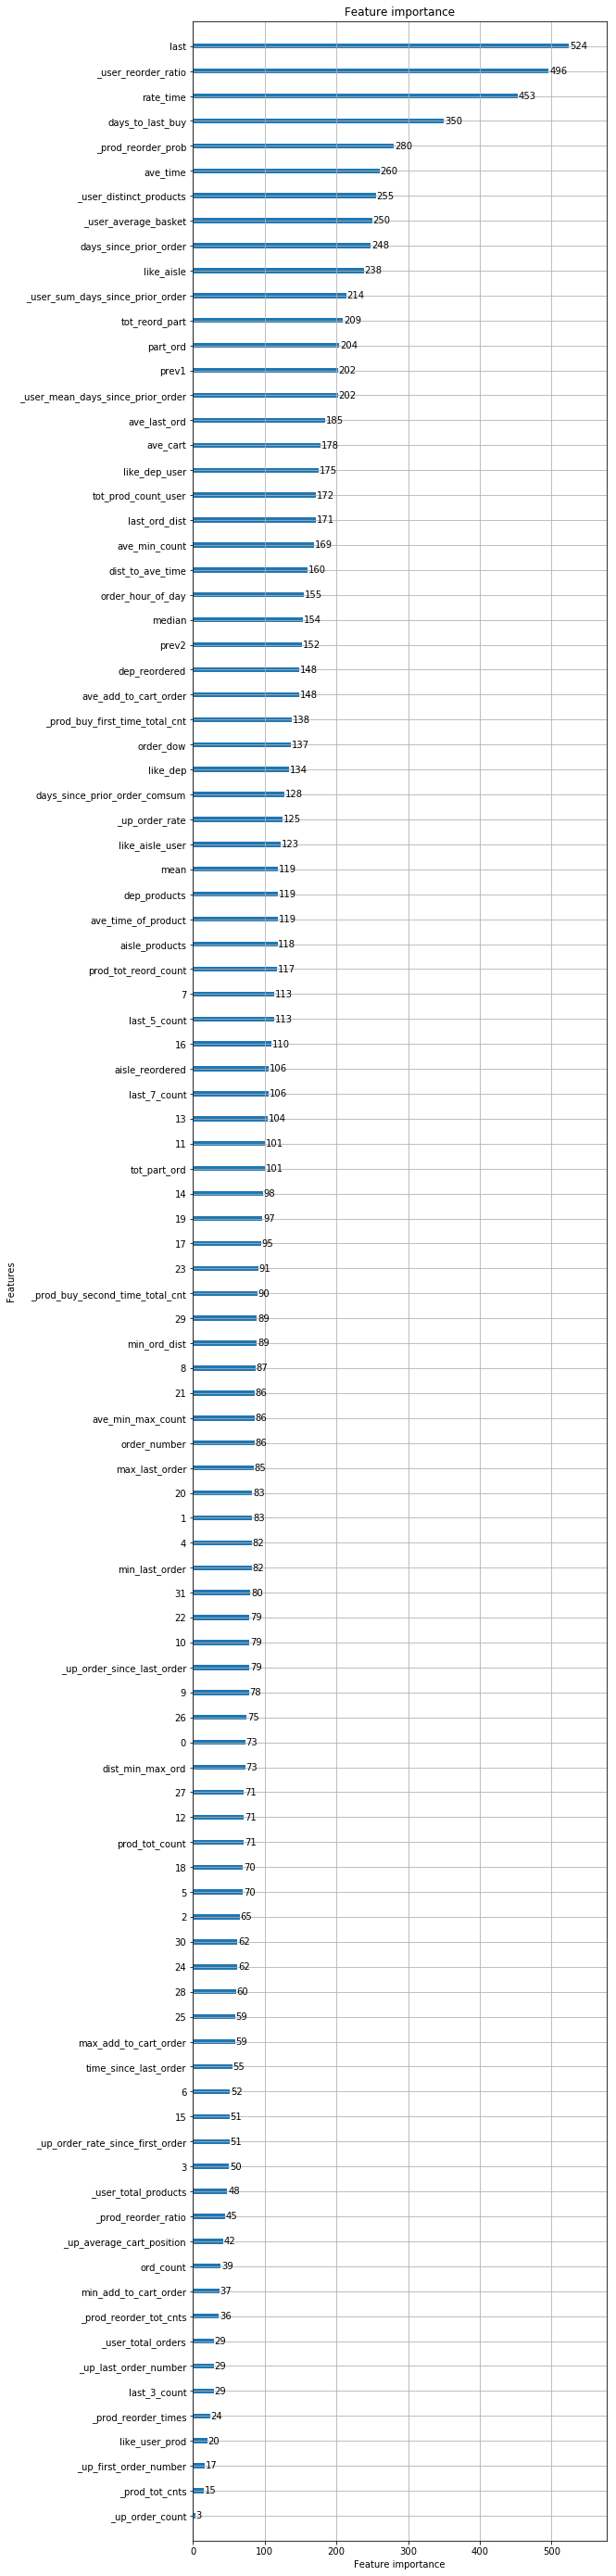

In [29]:
lgbm.plot_importance(lgb, max_num_features=150,figsize=(8, 50))
plt.show()


In [ ]:
0.243793
0.244334
0.244372
0.244874
0.244969
0.245499
0.245540
0.245933

In [16]:
X_train['pred'] = pred_train

In [114]:
tmp = X_train[['order_id_x', 'product_id', 'pred']]
tmp.columns = ['order_id', 'product_id', 'pred']
tmp.to_csv('my_pub_train.csv', index=False)

In [5]:
# -*- coding: utf-8 -*-
"""
@author: Faron, cpmp
"""
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
from numba import jit

'''
This kernel implements the O(n²) F1-Score expectation maximization algorithm presented in
"Ye, N., Chai, K., Lee, W., and Chieu, H.  Optimizing F-measures: A Tale of Two Approaches. In ICML, 2012."

It solves argmax_(0 <= k <= n,[[None]]) E[F1(P,k,[[None]])]
with [[None]] being the indicator for predicting label "None"
given posteriors P = [p_1, p_2, ... , p_n], where p_1 > p_2 > ... > p_n
under label independence assumption by means of dynamic programming in O(n²).
'''


class F1Optimizer():
    def __init__(self):
        pass

    @staticmethod
    @jit
    def get_expectations(P, pNone=None):
        expectations = []
        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        return np.array(expectations[::-1]).T

    @staticmethod
    @jit
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)

        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
        max_f1 = expectations[ix_max]

        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        return best_k, predNone, max_f1

    @staticmethod
    def _F1(tp, fp, fn):
        return 2 * tp / (2 * tp + fp + fn)

    @staticmethod
    def _Fbeta(tp, fp, fn, beta=1.0):
        beta_squared = beta ** 2
        return (1.0 + beta_squared) * tp / ((1.0 + beta_squared) * tp + fp + beta_squared * fn)


def print_best_prediction(P, pNone=None):
    #print("Maximize F1-Expectation")
    #print("=" * 23)
    P = np.sort(P)[::-1]
    n = P.shape[0]
    L = ['L{}'.format(i + 1) for i in range(n)]

    if pNone is None:
        #print("Estimate p(None|x) as (1-p_1)*(1-p_2)*...*(1-p_n)")
        pNone = (1.0 - P).prod()

    PL = ['p({}|x)={}'.format(l, p) for l, p in zip(L, P)]
    #print("Posteriors: {} (n={})".format(PL, n))
    #print("p(None|x)={}".format(pNone))

    opt = F1Optimizer.maximize_expectation(P, pNone)
    best_prediction = ['None'] if opt[1] else []
    best_prediction += (L[:opt[0]])
    f1_max = opt[2]
    #print(opt[0])
    #print("Prediction {} yields best E[F1] of {}\n".format(best_prediction, f1_max))
    return opt[0]

def save_plot(P, filename='expected_f1.png'):
    E_F1 = pd.DataFrame(F1Optimizer.get_expectations(P).T, columns=["/w None", "/wo None"])
    best_k, _, max_f1 = F1Optimizer.maximize_expectation(P)

    plt.style.use('ggplot')
    plt.figure()
    E_F1.plot()
    plt.title('Expected F1-Score for \n {}'.format("P = [{}]".format(",".join(map(str, P)))), fontsize=12)
    plt.xlabel('k')
    plt.xticks(np.arange(0, len(P) + 1, 1.0))
    plt.ylabel('E[F1(P,k)]')
    plt.plot([best_k], [max_f1], 'o', color='#000000', markersize=4)
    plt.annotate('max E[F1(P,k)] = E[F1(P,{})] = {:.5f}'.format(best_k, max_f1), xy=(best_k, max_f1),
                 xytext=(best_k, max_f1 * 0.8), arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7),
                 horizontalalignment='center', verticalalignment='top')
    plt.gcf().savefig(filename)



def timeit(P):
    s = datetime.now()
    F1Optimizer.maximize_expectation(P)
    e = datetime.now()
    return (e-s).microseconds / 1E6


def benchmark(n=100, filename='runtimes.png'):
    results = pd.DataFrame(index=np.arange(1,n+1))
    results['runtimes'] = 0

    for i in range(1,n+1):
        runtimes = []
        for j in range(5):
            runtimes.append(timeit(np.sort(np.random.rand(i))[::-1]))
        results.iloc[i-1] = np.mean(runtimes)

    x = results.index
    y = results.runtimes
    results['quadratic fit'] = np.poly1d(np.polyfit(x, y, deg=2))(x)

    plt.style.use('ggplot')
    plt.figure()
    results.plot()
    plt.title('Expectation Maximization Runtimes', fontsize=12)
    plt.xlabel('n = |P|')
    plt.ylabel('time in seconds')
    plt.gcf().savefig(filename)


In [32]:
def calc_approx_ef1(df_group):

    df = df_group.copy()
    order_id = np.int(df.iloc[0]['order_id'])
    
    df = df.sort_values('pred', ascending=False)[['product_id', 'pred', 'true']]
    products, preds = (zip(*df.sort_values('pred', ascending=False)[['product_id', 'pred']].values))
    _true = list(map(int, df['true'].values))
    pred_none = np.cumprod([1-x for x in preds])[-1]

    # add 'None' as product with p_none
    # ************************************************************
    
    products = list(products)[::-1]
    preds = list(preds)[::-1]
    ii = bisect.bisect(preds, pred_none)
    bisect.insort(preds, pred_none)
    products.insert(ii, 65535)
    products = products[::-1]
    preds = preds[::-1]
    # ************************************************************
    
    pi_sum = np.sum(preds)
    _len = len(products)
    mask = np.tril(np.ones((_len, _len)))
    hi_sum = mask.sum(1)

    phi_sum = 2*np.dot(mask, preds)
    ef1 = phi_sum / (pi_sum+hi_sum)

    ef1_max = np.max(ef1)

    prod_max = ' '.join(map(str, map(int, filter(bool, mask[np.argmax(ef1)]*products))))
    prod_list = prod_max.replace('65535', '65535') # if ef1_max > pred_none else 'None'

    return pd.DataFrame({'products':[prod_list], 'ef1':[ef1_max]})

In [131]:
X_train['true'] = 0

In [12]:
import gc
gc.collect()

268

In [133]:
dfg = X_train[['user_id', 'product_id', 'order_id', 'pred', 'true']].groupby(['order_id'])
df_ef1 = dfg.apply(lambda x: calc_approx_ef1(x))
df_ef1.reset_index(inplace=True)

In [136]:
df_ef1['products'] = df_ef1['products'].apply(lambda x: x.split())
df_ef1['products'] = df_ef1['products'].apply(lambda x: [int(i) for i in x])
del df_ef1['level_1']
del df_ef1['ef1']

In [88]:
print_best_prediction([0.6, 0.4], pNone=0.5)

NameError: name 'print_best_prediction' is not defined

In [104]:
tmp = pd.DataFrame(X_train.sort_values(['order_id','pred']).groupby('order_id')['pred'].aggregate(lambda x: tuple(x)))

In [117]:
t_start = time.clock()
res_cnt = tmp['pred'][:].apply(lambda x: print_best_prediction(x))
t_end = time.clock()
t_end-t_start


res_cnt = pd.DataFrame(X_train.sort_values(['order_id','pred']).groupby('order_id')['product_id'].aggregate(lambda x: tuple(x)))
res = pd.concat([res, res_cnt], axis=1)

3931.6807650000005

In [131]:
val = []
for product_id, res in tmp[:].values:
    val += [product_id[-res:]]

In [175]:
res['product_id'] = val
res['order_id'] = res.index

In [53]:
tr_y.index = range(len(tr_y))

In [107]:
f1_score([[None], [1, 2]], [[None], [4, 2]])

0.75

In [137]:
f1_score(tr_y['products'], df_ef1['products'])

0.37992610581347819

In [ ]:
0.37996139085153019

In [183]:
len(res)

131209

In [77]:
tr_y = pd.DataFrame(train.groupby('order_id')['product_id'].aggregate(lambda x: tuple(x)))
tr_y['order_id'] = tr_y.index
tmp = pd.DataFrame(tr_y['order_id'])

tr_y = pd.DataFrame(train[train.reordered==1].groupby('order_id')['product_id'].aggregate(lambda x: tuple(x)))
tr_y['product_id'] = tr_y['product_id'].apply(lambda x: list(x))

tr_y['order_id'] = tr_y.index

In [58]:
len(tr_y)

131209

In [78]:
res = pd.merge(tmp, res, on=['order_id'], how='left')
res.index = tmp.index
res.columns = ['order_id','products']
res = res.fillna('')

NameError: name 'res' is not defined

In [79]:

tr_y = pd.merge(tmp, tr_y, on=['order_id'], how='left')
tr_y.index = tmp.index
tr_y.columns = ['order_id','products']
tr_y = tr_y.fillna('')

In [80]:
tmp = []
for i in tr_y['products']:
    if i == '':
        tmp += [[]]
    else:
        tmp += [i]
tr_y['products'] = tmp

In [187]:
tmp = []
for i in res['products']:
    if i == '':
        tmp += [[]]
    else:
        tmp += [i]
res['products'] = tmp


tmp = []
for i in tr_y['products']:
    if i == '':
        tmp += [[]]
    else:
        tmp += [i]
tr_y['products'] = tmp

In [16]:
X_train['pred'] = pred_train
X_train['pred'] = X_train['pred'] > 0.185

tr_y = pd.DataFrame(train.groupby('order_id')['product_id'].aggregate(lambda x: tuple(x)))
tr_y['order_id'] = tr_y.index
tmp = pd.DataFrame(tr_y['order_id'])

tr_y = pd.DataFrame(train[train.reordered==1].groupby('order_id')['product_id'].aggregate(lambda x: tuple(x)))
tr_y['product_id'] = tr_y['product_id'].apply(lambda x: list(x))

res = pd.DataFrame(X_train[X_train.pred].groupby('order_id')['product_id'].aggregate(lambda x: tuple(x)))
res['product_id'] = res['product_id'].apply(lambda x: list(x))

res['order_id'] = res.index
tr_y['order_id'] = tr_y.index

res = pd.merge(tmp, res, on=['order_id'], how='left')
res.index = tmp.index
res.columns = ['order_id','products']
res = res.fillna('')

tr_y = pd.merge(tmp, tr_y, on=['order_id'], how='left')
tr_y.index = tmp.index
tr_y.columns = ['order_id','products']
tr_y = tr_y.fillna('')

tmp = []
for i in res['products']:
    if i == '':
        tmp += [[]]
    else:
        tmp += [i]
res['products'] = tmp


tmp = []
for i in tr_y['products']:
    if i == '':
        tmp += [[]]
    else:
        tmp += [i]
tr_y['products'] = tmp

In [59]:
f1_score(tr_y.ix[res.index, 'products'], res.ix[:, 'products'])

NameError: name 'res' is not defined

In [ ]:
0.38427334040363975

In [ ]:
0.37370660212065726
0.37338596594352669
0.37275321576951187
0.37156955488712173
0.37170138617722104
0.37105389669479422
0.370843547871051

## Test

In [27]:
X_train_ = X_train.copy()

In [117]:
X_train[:5]

,product_id,order_id_x,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,ord_count,part_ord,ave_add_to_cart_order,...,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,order_id_y,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,pred
0,33120,1050357,202279,9,1,14,30.0,5,0.555556,2.000000,...,0.5375,90,47,11.25,1050357,30.0,0.625,0,0.625000,0.512450
1,28985,1050357,202279,9,1,14,30.0,5,0.555556,3.200000,...,0.5375,90,47,11.25,1050357,30.0,0.625,2,0.625000,0.285229
2,9327,1050357,202279,9,1,14,30.0,1,0.111111,3.000000,...,0.5375,90,47,11.25,1050357,30.0,0.125,5,0.166667,0.022736
3,45918,1050357,202279,9,1,14,30.0,5,0.555556,4.800000,...,0.5375,90,47,11.25,1050357,30.0,0.625,1,0.714286,0.254252
4,30035,1050357,202279,9,1,14,30.0,3,0.333333,4.666667,...,0.5375,90,47,11.25,1050357,30.0,0.375,1,0.500000,0.191346


In [31]:
del X_train

In [16]:
import gc
gc.collect()

184

In [9]:
del sample_submission['products']

X_train = pd.merge(sample_submission, orders, on=['order_id'], how='left')
prior_base = pd.merge(priors, orders, on=['order_id'], how='left')
prior_base = prior_base[['user_id', 'product_id']]
prior_base = prior_base.drop_duplicates()


tmp = pd.DataFrame(X_train.groupby('order_id')['user_id'].mean())
tmp['order_id'] = tmp.index
tmp.index = tmp.user_id
X_train = pd.merge(prior_base, tmp, on='user_id')
del X_train['user_id']
X_train = pd.merge(X_train, orders, on=['order_id'], how='left')
del X_train['eval_set']


X_train = pd.merge(X_train, train, on=['order_id', 'product_id'], how='left')
del X_train['add_to_cart_order']
X_train = X_train.fillna(0)

In [10]:
# Количество раз, которое был куплен товар пользователем
prior_base = pd.merge(priors, orders, on=['order_id'], how='left')
tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['order_id'].count())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'ord_count']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Доля товара в заказах
X_train['part_ord'] = X_train['ord_count'] / X_train['order_number']

# Среднее место в корзине
tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'ave_add_to_cart_order']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Макс место в корзине
tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['add_to_cart_order'].max())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'max_add_to_cart_order']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Мин место в корзине
tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['add_to_cart_order'].min())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'min_add_to_cart_order']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Число заказов пользователя
tmp = pd.DataFrame(prior_base.groupby(['user_id'])['product_id'].count())
tmp['user_id'] = tmp.index
tmp.columns = ['tot_prod_count_user', 'user_id']
X_train = pd.merge(X_train, tmp, on=['user_id'], how='left')

# Доля заказов продукта пользователем ко всем заказам пользователя
X_train['tot_part_ord'] = X_train['ord_count'] / X_train['tot_prod_count_user']

# Средний размер корзины
X_train['ave_cart'] = X_train['tot_prod_count_user'] / X_train['order_number']

# Количество раз, которое товар покупался всего 
tmp = pd.DataFrame(prior_base.groupby(['product_id'])['product_id'].count())
tmp.columns = ['prod_tot_count']
tmp['product_id'] = tmp.index
tmp.columns = ['prod_tot_count', 'product_id']
X_train = pd.merge(X_train, tmp, on=['product_id'], how='left')

# Количество раз, которое товар перепокупался всего 
tmp = pd.DataFrame(prior_base[prior_base.reordered==1].groupby(['product_id'])['product_id'].count())
tmp.columns = ['prod_tot_reord_count']
tmp['product_id'] = tmp.index
tmp.columns = ['prod_tot_reord_count', 'product_id']
X_train = pd.merge(X_train, tmp, on=['product_id'], how='left')

# Доля перепокупок
X_train['tot_reord_part'] = X_train['prod_tot_reord_count'] / X_train['prod_tot_count']

# Номер предыдущего заказа товара
tmp = pd.DataFrame(prior_base.groupby(['user_id','product_id'])['order_number'].max())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'max_last_order']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Расстояние до предыдущего заказа
X_train['last_ord_dist'] = X_train['order_number'] - X_train['max_last_order']

# Ордер, в котором товар был куплен первый раз
tmp = pd.DataFrame(prior_base.groupby(['user_id','product_id'])['order_number'].min())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'min_last_order']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

# Расстояние до первого заказа
X_train['min_ord_dist'] = X_train['order_number'] - X_train['min_last_order']

# Расстояние между первой и последней покупкой
X_train['dist_min_max_ord'] = X_train['max_last_order'] - X_train['min_last_order']
# Среднее число заказов товара за ордер в этот период
X_train['ave_min_max_count'] = X_train['ord_count'] / X_train['dist_min_max_ord']

# Среднее число заказов товара за ордер с момента первой покупки
X_train['ave_min_count'] = X_train['ord_count'] / X_train['min_ord_dist']

# Среднее время между заказами
tmp = pd.DataFrame(prior_base.groupby(['user_id'])['days_since_prior_order'].mean())
tmp.columns = ['ave_time']
tmp['user_id'] = tmp.index
tmp.columns = ['ave_time', 'user_id']
X_train = pd.merge(X_train, tmp, on=['user_id'], how='left')

# Отношение времени до предыдущего заказа к среднему
X_train['rate_time'] = X_train['days_since_prior_order'] / X_train['ave_time']

In [11]:
X_train = pd.merge(X_train, products, on=['product_id'], how='left')
del X_train['product_name']

prior_base = pd.merge(prior_base, products, on=['product_id'], how='left')
prior_base = pd.merge(prior_base, pd.DataFrame(X_train[['user_id', 'product_id','max_last_order']]), on=['user_id', 'product_id'], how='left')

tmp = X_train[['user_id', 'product_id', 'order_number']]
tmp.columns = ['user_id', 'product_id', 'cur_order_number']
prior_base = pd.merge(prior_base, tmp, on=['user_id', 'product_id'], how='left')
prior_base['dist_to_ord'] = prior_base['cur_order_number'] - prior_base['order_number']


# Время в днях с последнего заказа пользователем этого товара
tmp = pd.DataFrame(prior_base.groupby(['user_id','order_number'])['order_id', 'days_since_prior_order'].mean())
tmp.reset_index(inplace=True)
del tmp['order_id']

tmp1 = pd.DataFrame(prior_base.groupby(['user_id','product_id'])['max_last_order'].mean())
tmp1.reset_index(inplace=True)

mask = pd.merge(tmp, tmp1, on=['user_id'], how='inner')['max_last_order'] < pd.merge(tmp, tmp1, on=['user_id'], how='inner')['order_number']
base = pd.merge(tmp, tmp1, on=['user_id'], how='inner')[mask]
base = pd.DataFrame(base.groupby(['user_id', 'product_id'])['days_since_prior_order'].sum())
base.columns = ['days_to last_buy']

base.reset_index(inplace=True)
X_train = pd.merge(X_train, base, on=['user_id', 'product_id'], how='left')



# Среднее число дней до предыдущего заказа по товару
tmp = pd.DataFrame(prior_base.groupby(['user_id','product_id'])['days_since_prior_order'].mean())
tmp.reset_index(inplace=True)
tmp.columns = ['user_id', 'product_id', 'ave_last_ord']
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

In [12]:
tmp = pd.DataFrame(prior_base.groupby(['department_id'])['reordered'].mean())
tmp.columns = ['like_dep']
tmp['department_id'] = tmp.index
tmp.columns = ['like_dep', 'department_id']
X_train = pd.merge(X_train, tmp, on=['department_id'], how='left')

tmp = pd.DataFrame(prior_base.groupby(['aisle_id'])['reordered'].mean())
tmp.columns = ['like_aisle']
tmp['aisle_id'] = tmp.index
tmp.columns = ['like_aisle', 'aisle_id']
X_train = pd.merge(X_train, tmp, on=['aisle_id'], how='left')

tmp = pd.DataFrame(prior_base.groupby(['department_id', 'user_id'])['reordered'].mean())
tmp.columns = ['like_dep_user']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['department_id', 'user_id'], how='left')

tmp = pd.DataFrame(prior_base.groupby(['aisle_id', 'user_id'])['reordered'].mean())
tmp.columns = ['like_aisle_user']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['aisle_id', 'user_id'], how='left')

tmp = pd.DataFrame(prior_base.groupby(['user_id', 'product_id'])['reordered'].mean())
tmp.columns = ['like_user_prod']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')

In [13]:
# Сколько раз товар покупался пользователем за последние 3 заказа
tmp = pd.DataFrame(prior_base[prior_base.dist_to_ord <= 3].groupby(['user_id', 'product_id'])['order_id'].count())
tmp.columns = ['last_3_count']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')
X_train['last_3_count'] = X_train['last_3_count'].fillna(0)

# Сколько раз товар покупался пользователем за последние 5 заказа
tmp = pd.DataFrame(prior_base[prior_base.dist_to_ord <= 5].groupby(['user_id', 'product_id'])['order_id'].count())
tmp.columns = ['last_5_count']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')
X_train['last_5_count'] = X_train['last_5_count'].fillna(0)

# Сколько раз товар покупался пользователем за последние 7 заказа
tmp = pd.DataFrame(prior_base[prior_base.dist_to_ord <= 7].groupby(['user_id', 'product_id'])['order_id'].count())
tmp.columns = ['last_7_count']
tmp.reset_index(inplace=True)
X_train = pd.merge(X_train, tmp, on=['user_id', 'product_id'], how='left')
X_train['last_7_count'] = X_train['last_7_count'].fillna(0)


# Среднее время, когда покупался товар
tmp = pd.DataFrame(prior_base.groupby(['product_id'])['order_hour_of_day'].mean())
tmp['product_id'] = tmp.index
tmp.columns = ['ave_time_of_product', 'product_id']
X_train = pd.merge(X_train, tmp, on=['product_id'], how='left')

# Время до среднего времени заказа этого товара
X_train['dist_to_ave_time'] = np.abs(X_train['ave_time_of_product'] - X_train['order_hour_of_day'])

In [22]:
X_train[:3]

,product_id,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered,ord_count,part_ord,...,like_dep,like_aisle,like_dep_user,like_aisle_user,like_user_prod,last_3_count,last_5_count,last_7_count,ave_time_of_product,dist_to_ave_time
0,17330,65432,45082,11,4,12,15.0,0.0,1,0.090909,...,0.569924,0.565304,0.0,0.0,0.0,0.0,0.0,0.0,13.268595,1.268595
1,27407,65432,45082,11,4,12,15.0,0.0,1,0.090909,...,0.346721,0.469100,0.0,0.0,0.0,0.0,0.0,0.0,13.617828,1.617828
2,35419,65432,45082,11,4,12,15.0,0.0,1,0.090909,...,0.569924,0.572344,0.0,0.0,0.0,0.0,0.0,0.0,14.147910,2.147910


In [14]:
del X_train['reordered']

In [15]:
X_train_public = pd.read_csv('public_test.csv')
X_train_public.fillna(0, inplace=True)
del X_train_public['reordered']
X_train = pd.merge(X_train, X_train_public, on=['user_id', 'product_id'], how='left')

In [16]:
df = pd.read_pickle('imba/data/user_department_products.pkl')
X_train = pd.merge(X_train, df, on=['user_id', 'department_id'], how='left')
df = pd.read_pickle('imba/data/user_aisle_products.pkl')
X_train = pd.merge(X_train, df, on=['user_id', 'aisle_id'], how='left')
df = pd.read_pickle('imba/data/product_periods_stat.pkl')
X_train = pd.merge(X_train, df, on=['user_id', 'product_id'], how='left')
df = pd.read_pickle('imba/data/product_embeddings.pkl')
del df['product_name']
X_train = pd.merge(X_train, df, on=['product_id'], how='left')
df = pd.read_pickle('imba/data/orders_comsum.pkl')
X_train = pd.merge(X_train, df, on=['user_id', 'order_number'], how='left')

In [19]:
del X_train['product_id']
del X_train['order_id_x']
del X_train['department_id_x']
del X_train['aisle_id_x']
del X_train['order_id_y']
del X_train['eval_set']
del X_train['aisle_id_y']
del X_train['department_id_y']

In [17]:
del X_train['user_id']

In [20]:
X_train[:3]

,order_number,order_dow,order_hour_of_day,days_since_prior_order,ord_count,part_ord,ave_add_to_cart_order,max_add_to_cart_order,min_add_to_cart_order,tot_prod_count_user,...,23,24,25,26,27,28,29,30,31,days_since_prior_order_comsum
0,11,4,12,15.0,1,0.090909,1.0,1,1,67,...,1.177001,0.420436,-0.241807,-0.373233,-0.741965,-0.190637,-0.434844,0.955453,0.614790,83.0
1,11,4,12,15.0,1,0.090909,2.0,2,2,67,...,0.544554,0.269158,0.256089,0.578440,-0.883728,-0.902744,-0.467266,-0.266802,-0.032882,83.0
2,11,4,12,15.0,1,0.090909,3.0,3,3,67,...,0.389326,0.926182,0.409069,-0.884879,-0.232139,-0.625273,0.641618,0.690887,0.495006,83.0


In [34]:
X_train.to_csv('te.csv', index=False)

OSError: [Errno 28] No space left on device

In [ ]:
1

In [ ]:
X_train['product_id'] = 0

In [23]:
test_pred = lgb.predict_proba(X_train.ix[:, :])[:, 1]


/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [24]:
test_pred

array([ 0.02670364,  0.02256627,  0.02197021, ...,  0.11218608,
        0.16823318,  0.15425495])

In [25]:
X_train['pred'] = test_pred

In [26]:
tmp = X_train[['pred']]
tmp.to_csv('m.csv', index=False)

In [21]:
test_pred.max()

0.94550065364403602

In [190]:
import scipy.stats as st
print(st.spearmanr(t1.pred, t4.pred)[0])

0.996746307596


In [41]:
X_train.shape

(4833292, 42)

In [22]:
tmp = pd.DataFrame(X_train.sort_values(['order_id','pred']).groupby('order_id')['pred'].aggregate(lambda x: tuple(x)))

In [23]:
t_start = time.clock()
res_cnt = tmp['pred'][:].apply(lambda x: print_best_prediction(x))
t_end = time.clock()
print(t_end-t_start)

res = pd.DataFrame(X_train.sort_values(['order_id','pred']).groupby('order_id')['product_id'].aggregate(lambda x: tuple(x)))
res = pd.concat([res, res_cnt], axis=1)

2186.464405


In [24]:
1

1

In [25]:
1

1

In [26]:
val = []
for product_id, pred in res[:].values:
    val += [product_id[-pred:]]

In [27]:
res['product_id'] = val
res['order_id'] = res.index

In [28]:
del res['pred']

In [99]:
len(res)

75000

In [155]:
res_ = res

In [61]:
res = res_

In [29]:
res = pd.merge(sample_submission, res, on=['order_id'], how='left')
res.index = sample_submission.index
res.columns = ['order_id','products']
res = res.fillna('')

In [45]:
len(res)

75000

In [30]:
tmp = []
for i in res['products']:
    if i == '':
        tmp += [[]]
    else:
        tmp += [i]
res['products'] = tmp

In [31]:
tmp = []
for i in res['products']:
    if i == '':
        tmp += ['']
    else:
        st = ''
        for j in i:
            st += ' '+str(j)
        tmp += [st]
res['products'] = tmp

In [32]:
res.to_csv('blend_045.csv', index=False)

In [44]:
orders.groupby('user_id')['order_id'].count().mean()

16.590367054784224

In [33]:
res

,order_id,products
0,17,38777 21709 47766 21463 13107
1,34,44632 13176 39180 44663 2596 47792 43504 2113...
2,137,2326 5134 25890 41787 38689 23794 24852
3,182,32109 41149 47209 11520 33000 47672 13629 547...
4,257,28476 21137 24838 45013 30233 29837 39475 279...
5,313,25890 28535 30391 13198 46906 21903 12779 45007
6,353,33000 21137 40688 35561
7,386,6046 2326 35221 17652 37935 25513 8174 28985 ...
8,414,36865 35221 31215 21376 19006 7539 44292 4472...
9,418,12036 5262 1503 38694 41950 13702 30489 40268...
